In [4]:
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, RobertaTokenizer, AutoModelForQuestionAnswering
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import wandb
from datasets import Dataset
import os
from collections import defaultdict
import numpy as np
from torch.utils.data import DataLoader
from transformers import AdamW
import evaluate
from transformers import default_data_collator
from transformers import Trainer
from tqdm.auto import tqdm
from transformers import TrainingArguments
from accelerate import Accelerator
from transformers import get_scheduler
# import gradio as gr
import re

os.environ["TOKENIZERS_PARALLELISM"] = "false"

tqdm.pandas()

In [3]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
errorUuid = {"ad9271b7-9983-42f5-9bd9-fdfcb171ddaa":[[[4, 37],[4, 222]]]}
def parse_spoiler(x):
    spoiler = []
    if x['uuid'] in errorUuid:
        x['spoilerPositions'] = errorUuid[x['uuid']]

    for s in x['spoilerPositions']:
        st,en = s[0],s[1]
        spoiler.append(x['targetParagraphs'][st[0]][st[1]:en[1]])
        
    return spoiler

def findPosTags(x):    
    tokPos = []
    for pos in x['spoilerPositions']:
        st,en = pos
        idx = 0
        for i,p in enumerate([x['targetTitle']] + x['targetParagraphs']):
            if i==st[0]+1:
                start_ind = idx+st[1]
                end_ind = idx + en[1]
                
                tokPos.append([start_ind,end_ind])
                break
            if i==0:
                idx+=len(p)+3
            else:
                idx+=len(p)+1
        
    return tokPos

def read_prep(path,train=True):
    with open(path, 'rb') as json_file:
        json_list = list(json_file)

    results = []
    for json_str in json_list:
        result = json.loads(json_str)
        results.append(result)
    df = pd.DataFrame(results)
    df['tags'] = df.tags.apply(lambda x:x[0],1)
    df['postText'] = df.postText.apply(lambda x:x[0],1)    
    
    # Parsing for faulty spoiler ids
    df['spoilerParsed'] = df.apply(parse_spoiler,1)
    df['mergedParas'] = df['targetParagraphs'].apply(lambda x:" ".join(x),1)
    df.mergedParas = df.targetTitle + " - " + df.mergedParas
    df['tokPos'] = df.apply(findPosTags,1)
    df['label'] = df['tags'].map({"phrase":0,"passage":1,"multi":2})
    
    return df

In [6]:
df_train = read_prep("/kaggle/input/webisclickbait/webis-clickbait-22/train.jsonl")
df_valid = read_prep("/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl")

**MULTI DATASET**

In [10]:
df_valid[df_valid['tags'] == 'multi']

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags,spoilerParsed,mergedParas,tokPos,label
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,4jp20e,Why Arizona Sheriff Joe Arpaio’s fate could ha...,reddit,[© REUTERS/Laura Segall Maricopa County Sherif...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"<p>A single word — ""intentionally"" — could tra...",None,[https://archive.is/0eGBT/bbf6d79b366fc7e75b8b...,https://archive.is/0eGBT,"{'source': 'anonymized', 'humanSpoiler': '""Int...","[""intentionally"", could transform a court case...","[[[0, 197], [0, 212]], [[0, 215], [0, 328]]]",multi,"[""intentionally"", could transform a court case...",Why Arizona Sheriff Joe Arpaio’s fate could ha...,"[[265, 280], [283, 396]]",2
3,8b713277-0e5b-4873-a216-b650f21f3b4c,389091583213453312,"""Harry Potter"" alums reunite for new movie",Twitter,[The mythology of punk music's evolution can b...,"Alan Rickman & Rupert Grint On 'CBGB,' Reuniti...",The mythology of punk music's evolution can be...,"Alan Rickman,Hilly Kristal,new rupert grint mo...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1ccNwKJ,"{'source': 'anonymized', 'humanSpoiler': 'Alan...","[Alan Rickman & Rupert Grint, CBGB]","[[[-1, 0], [-1, 27]], [[0, 98], [0, 102]]]",multi,"[""CBGB"" is out in limited re, CBGB]","Alan Rickman & Rupert Grint On 'CBGB,' Reuniti...","[[0, 27], [195, 199]]",2
10,57c972a1-0fe2-4bef-a71f-1d56561e4a3b,382646673979498497,How 1 model prepares for lingerie shoots,Twitter,[The life of a lingerie model is quite a forei...,"Elettra Wiedemann, Agent Provocateur Model, Ex...",The life of a lingerie model is quite a foreig...,"video,Agent Provocateur lingerie,Agent Provoca...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1eDU4Wk,"{'source': 'anonymized', 'humanSpoiler': 'Elet...","[Elettra Wiedemann, extra strength work, so we...","[[[0, 190], [0, 207]], [[4, 18], [4, 172]]]",multi,"[Elettra Wiedemann, extra strength work, so we...","Elettra Wiedemann, Agent Provocateur Model, Ex...","[[283, 300], [1014, 1168]]",2
13,59a80c2a-4f64-4ba6-a87c-712dd5208f7d,414459946798182400,The question former O.J. Simpson prosecutor ha...,Twitter,[As the lead prosecutor in the O.J. Simpson mu...,Former Prosecutor Marcia Clark On Life After T...,As the lead prosecutor in the O.J. Simpson mur...,"O.J. Simpson,Marcia Clark,Rachel Knight,Rachel...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cWwQsq,"{'source': 'anonymized', 'humanSpoiler': 'Does...","[Marcia Clark, Does she think Simpson really d...","[[[0, 56], [0, 68]], [[5, 83], [5, 120]]]",multi,"[Marcia Clark, Does she think Simpson really d...",Former Prosecutor Marcia Clark On Life After T...,"[[134, 146], [1524, 1561]]",2
14,6e4a3235-bc25-4b10-9609-26c0b940b417,382921628117504001,Hollywood legend's amazing home is on the market,Twitter,[Hollywood legend Mitzi Gaynor is reportedly s...,Mitzi Gaynor's California Home For Sale Has Ho...,Hollywood legend Mitzi Gaynor is reportedly se...,"video,mitzi gaynor home for sale,Mitzi Gaynor,...",[http://i.huffpost.com/gen/1372396/images/o-MI...,http://huff.to/1eGIhXc,"{'source': 'anonymized', 'humanSpoiler': 'Mitz...","[Mitzi Gaynor, Beverly Hills, California]","[[[0, 17], [0, 29]], [[0, 56], [0, 81]]]",multi,"[Mitzi Gaynor, Beverly Hills, California]",Mitzi Gaynor's California Home For Sale Has Ho...,"[[132, 144], [171, 196]]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,f58a4966-910d-45e0-b1ed-bc6f612a3c96,852556983509155840,6 transcendental festivals out in the middle o...,Twitter,"[Some festivals are about music, some are abou...",7 transcendental festivals out in the middle o...,Some festivals are about music; some are about...,"Festivals, Features, Music, Culture",None,https://www.independent.co.uk/arts-entertainme...,"{'source': 'anonymized', 'humanSpoiler': None,...","[BOOM – Portugal

In [11]:
def convert2squadFormat(df):
    df_fin = df[['uuid','targetTitle','postText',"mergedParas","tokPos","spoiler"]]
    df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
    df_fin = df_fin.drop(columns=["tokPos","spoiler"])
    df_fin.columns = ["id","title","question","context","answers"]
    
    return df_fin


In [12]:
pip install -U nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [13]:
bleu = evaluate.load("bleu")
squad_metric = evaluate.load("squad")
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [14]:
def preprocess_training_examples(examples):
    questions = examples['question']
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [15]:
def preprocess_validation_examples(examples):
    questions = examples["question"]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [16]:

def compute_metrics(start_logits, end_logits, features, examples, predictOnly=False):
    example_to_features = defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_spoilers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        spoilers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]
            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    spoilers.append(answer)

        # Select the answer with the best score
        if len(spoilers) > 0:
            best_answer = max(spoilers, key=lambda x: x["logit_score"])
            predicted_spoilers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_spoilers.append({"id": example_id, "prediction_text": ""})
            
    predicted_texts = [i['prediction_text'] for i in predicted_spoilers]
    output = pd.DataFrame(predicted_spoilers)
    if predictOnly:
        return predicted_texts
    
    actual_spoilers_squad = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    actual_spoilers = [i['answers']['text'][0] for i in actual_spoilers_squad]    
    
    squad_metrics_eval = squad_metric.compute(predictions=predicted_spoilers, references=actual_spoilers_squad)
    bleu_eval = bleu.compute(predictions=predicted_texts, references=actual_spoilers)

    #Calculate the METEOR score using NLTK
    meteor_scores = meteor.compute(predictions=predicted_texts, references=actual_spoilers)

    return [squad_metrics_eval,bleu_eval],actual_spoilers,predicted_texts,meteor_scores


**MULTI DATASET**

In [17]:
# Based on spoiler type you want to train, "phrase" can be replaced with "passage"
spoiler_type = "multi"
train_df = df_train[df_train.tags==spoiler_type]
val_df = df_valid[df_valid.tags==spoiler_type]

len(train_df),len(val_df)

(559, 143)

In [18]:
train_df = convert2squadFormat(train_df)
val_df = convert2squadFormat(val_df)

train_data = Dataset.from_pandas(train_df.reset_index(drop=True), split="train")
val_data = Dataset.from_pandas(val_df.reset_index(drop=True), split="test")

/tmp/ipykernel_29/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
/tmp/ipykernel_29/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)


In [19]:
model_name = "deepset/roberta-base-squad2"

config = dict(
max_length = 512,
stride = 128,
n_best = 25,
max_answer_length = 30,
batch_size = 8,
epochs = 5,
learning_rate = 1e-6,
model_name = model_name,
spoiler_type = "phrase"
)


max_length = config["max_length"]
stride = config["stride"]
n_best = config["n_best"]
max_answer_length = config["max_answer_length"]



tokenizer = AutoTokenizer.from_pretrained(config["model_name"])
model = AutoModelForQuestionAnswering.from_pretrained(config["model_name"])

In [20]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)

validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
from accelerate import Accelerator
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=config["batch_size"],
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8 
)

optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

num_train_epochs = config["epochs"]
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
import io 
progress_bar = tqdm(range(num_training_steps))


all_metrics = []
max_bleu = 0.35
for epoch in range(num_train_epochs):
    # Training
    model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss+=loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics,theoretical_texts,predicted_texts,meteor_scores = compute_metrics(
        start_logits, end_logits, validation_dataset, val_data
    )
    all_metrics.append(metrics)
    if metrics[1]['bleu']>max_bleu:
        model.save_pretrained(f"./models_task2_{spoiler_type}/")
        max_bleu = metrics[1]['bleu']
    print(f"epoch {epoch}:", meteor_scores)

  0%|          | 0/1005 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

epoch 0: {'meteor': 0.3405270079717617}
Evaluation!


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

epoch 1: {'meteor': 0.44402407669460486}
Evaluation!


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

epoch 2: {'meteor': 0.4812098309090802}
Evaluation!


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

epoch 3: {'meteor': 0.48514670482533756}
Evaluation!


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

epoch 4: {'meteor': 0.48649151386245426}


In [23]:
dfs_list = []

# Loop through your data, assuming 'data_list' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Process each data to create a DataFrame (if needed)
    df = pd.DataFrame(all_metrics[data][0],index=[0])
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate the DataFrames along the rows (axis=0)
resulting_dataframe_roberta_multi_Em = pd.concat(dfs_list, axis=0)

In [24]:
resulting_dataframe_roberta_multi_Em

,exact_match,f1
0,36.363636,50.921574
0,48.251748,61.450200
0,51.748252,64.269704
0,51.748252,64.326246
0,51.748252,64.413658


In [25]:
dfs_list = []

# Loop through your data, assuming 'all_metrics' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Create a DataFrame from the dictionary element
    
    # Calculate the maximum value from the 'precisions' list
    all_metrics[data][1]['precisions'] = np.max(all_metrics[data][1]['precisions'])
    
    df = pd.DataFrame(all_metrics[data][1],index=[0])
    
    # Append the DataFrame to the list
    dfs_list.append(df)
resulting_dataframe_roberta_multi_Belu = pd.concat(dfs_list, ignore_index=True)

In [26]:
resulting_dataframe_roberta_multi_Belu

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length
0,0.195726,0.400000,0.583055,0.649573,760,1170
1,0.296025,0.524841,0.612353,0.670940,785,1170
2,0.335267,0.563817,0.637747,0.689744,807,1170
3,0.339999,0.596129,0.600689,0.662393,775,1170
4,0.340258,0.595882,0.603028,0.664103,777,1170


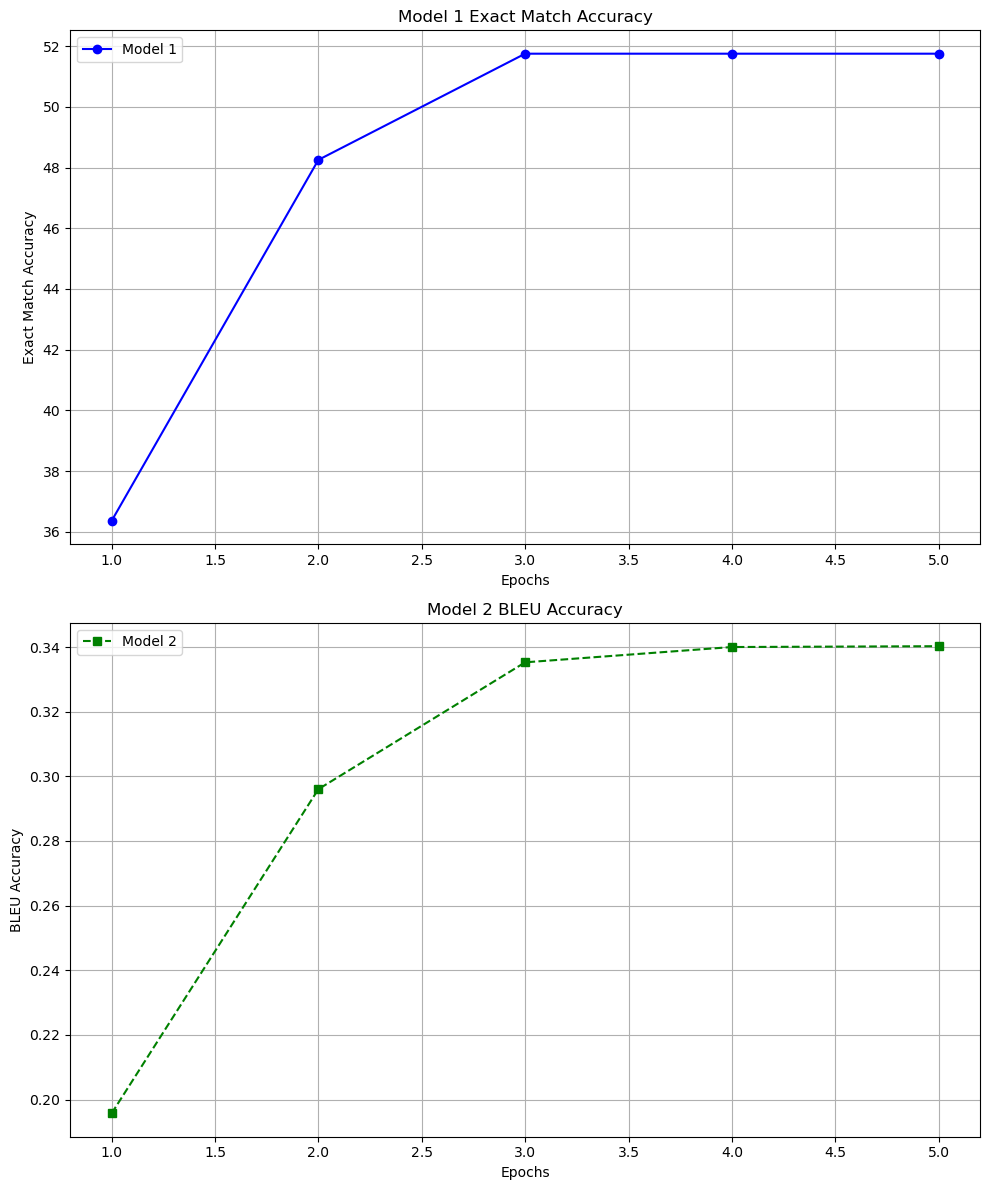

In [27]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]



# Create subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Model 1 accuracy on the first subplot
axs[0].plot(epochs, resulting_dataframe_roberta_multi_Em['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Exact Match Accuracy')
axs[0].set_title('Model 1 Exact Match Accuracy')
axs[0].grid(True)
axs[0].legend()

# Plot Model 2 accuracy on the second subplot
axs[1].plot(epochs, resulting_dataframe_roberta_multi_Belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Accuracy')
axs[1].set_title('Model 2 BLEU Accuracy')
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


**PHRASE DATASET**

In [50]:
# Based on spoiler type you want to train, "phrase" can be replaced with "passage"
spoiler_type = "phrase"
train_df = df_train[df_train.tags==spoiler_type]
val_df = df_valid[df_valid.tags==spoiler_type]

len(train_df),len(val_df)

(1367, 335)

In [51]:
train_df = convert2squadFormat(train_df)
val_df = convert2squadFormat(val_df)

train_data = Dataset.from_pandas(train_df.reset_index(drop=True), split="train")
val_data = Dataset.from_pandas(val_df.reset_index(drop=True), split="test")

/tmp/ipykernel_29/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
/tmp/ipykernel_29/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)


In [52]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)

validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [53]:
from accelerate import Accelerator
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=config["batch_size"],
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8 
)

optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

num_train_epochs = config["epochs"]
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [54]:
import io 
progress_bar = tqdm(range(num_training_steps))


all_metrics = []
max_bleu = 0.35
for epoch in range(num_train_epochs):
    # Training
    model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss+=loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics,theoretical_texts,predicted_texts,meteor_scores = compute_metrics(
        start_logits, end_logits, validation_dataset, val_data
    )
    all_metrics.append(metrics)
    if metrics[1]['bleu']>max_bleu:
        model.save_pretrained(f"./models_task2_{spoiler_type}/")
        max_bleu = metrics[1]['bleu']
    print(f"epoch {epoch}:", meteor_scores)

  0%|          | 0/1485 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

epoch 0: {'meteor': 0.5642125042435324}
Evaluation!


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

epoch 1: {'meteor': 0.5656933124211286}
Evaluation!


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

epoch 2: {'meteor': 0.5699579472953509}
Evaluation!


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

epoch 3: {'meteor': 0.5720966046578888}
Evaluation!


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

epoch 4: {'meteor': 0.574493351084486}


In [57]:
dfs_list = []

# Loop through your data, assuming 'data_list' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Process each data to create a DataFrame (if needed)
    df = pd.DataFrame(all_metrics[data][0],index=[0])
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate the DataFrames along the rows (axis=0)
resulting_dataframe_roberta_phrase_Em = pd.concat(dfs_list, axis=0)

In [1]:
resulting_dataframe_roberta_phrase_Em

NameError: name 'resulting_dataframe_roberta_phrase_Em' is not defined

In [58]:
dfs_list = []

# Loop through your data, assuming 'all_metrics' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Create a DataFrame from the dictionary element
    
    # Calculate the maximum value from the 'precisions' list
    all_metrics[data][1]['precisions'] = np.max(all_metrics[data][1]['precisions'])
    
    df = pd.DataFrame(all_metrics[data][1],index=[0])
    
    # Append the DataFrame to the list
    dfs_list.append(df)
resulting_dataframe_roberta_phrase_Belu = pd.concat(dfs_list, ignore_index=True)

In [36]:
resulting_dataframe_roberta_phrase_Belu

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length
0,0.242593,0.504032,1.0,1.161593,992,854
1,0.280036,0.539112,1.0,1.107728,946,854
2,0.288557,0.549947,1.0,1.113583,951,854
3,0.312049,0.570485,1.0,1.063232,908,854
4,0.342332,0.594966,1.0,1.023419,874,854


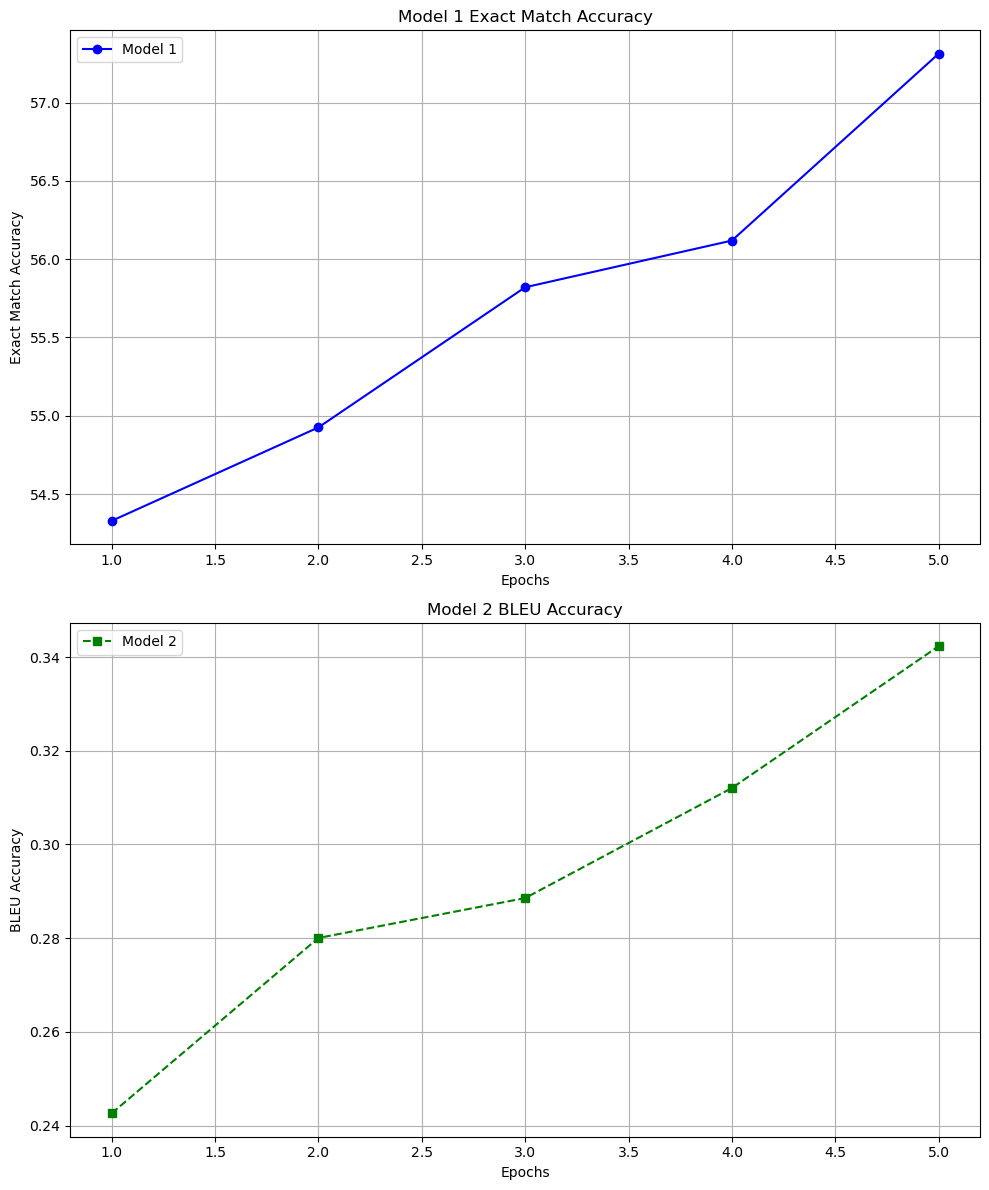

In [37]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]



# Create subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Model 1 accuracy on the first subplot
axs[0].plot(epochs, resulting_dataframe_roberta_phrase_Em['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Exact Match Accuracy')
axs[0].set_title('Model 1 Exact Match Accuracy')
axs[0].grid(True)
axs[0].legend()

# Plot Model 2 accuracy on the second subplot
axs[1].plot(epochs, resulting_dataframe_roberta_phrase_Belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Accuracy')
axs[1].set_title('Model 2 BLEU Accuracy')
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


**PASSAGE DATASET**

In [38]:
# Based on spoiler type you want to train, "phrase" can be replaced with "passage"
spoiler_type = "passage"
train_df = df_train[df_train.tags==spoiler_type]
val_df = df_valid[df_valid.tags==spoiler_type]

len(train_df),len(val_df)

(1274, 322)

In [39]:
train_df = convert2squadFormat(train_df)
val_df = convert2squadFormat(val_df)

train_data = Dataset.from_pandas(train_df.reset_index(drop=True), split="train")
val_data = Dataset.from_pandas(val_df.reset_index(drop=True), split="test")

/tmp/ipykernel_29/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
/tmp/ipykernel_29/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)


In [40]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)

validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [41]:
from accelerate import Accelerator
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=config["batch_size"],
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8 
)

optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

num_train_epochs = config["epochs"]
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
import io 
progress_bar = tqdm(range(num_training_steps))


all_metrics = []
max_bleu = 0.35
for epoch in range(num_train_epochs):
    # Training
    model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss+=loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics,theoretical_texts,predicted_texts,meteor_scores = compute_metrics(
        start_logits, end_logits, validation_dataset, val_data
    )
    all_metrics.append(metrics)
    if metrics[1]['bleu']>max_bleu:
        model.save_pretrained(f"./models_task2_{spoiler_type}/")
        max_bleu = metrics[1]['bleu']
    print(f"epoch {epoch}:", meteor_scores)

  0%|          | 0/1625 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

epoch 0: {'meteor': 0.31562006455029934}
Evaluation!


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

epoch 1: {'meteor': 0.343601729198372}
Evaluation!


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

epoch 2: {'meteor': 0.3593594815589772}
Evaluation!


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

epoch 3: {'meteor': 0.3691431254482441}
Evaluation!


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

epoch 4: {'meteor': 0.36758214570220243}


In [44]:
dfs_list = []

# Loop through your data, assuming 'data_list' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Process each data to create a DataFrame (if needed)
    df = pd.DataFrame(all_metrics[data][0],index=[0])
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate the DataFrames along the rows (axis=0)
resulting_dataframe_roberta_passage_Em = pd.concat(dfs_list, axis=0)

In [45]:
resulting_dataframe_roberta_passage_Em

,exact_match,f1
0,11.180124,34.508968
0,13.354037,37.160793
0,14.285714,38.581774
0,14.906832,39.560637
0,14.285714,39.439414


In [46]:
dfs_list = []

# Loop through your data, assuming 'all_metrics' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Create a DataFrame from the dictionary element
    
    # Calculate the maximum value from the 'precisions' list
    all_metrics[data][1]['precisions'] = np.max(all_metrics[data][1]['precisions'])
    
    df = pd.DataFrame(all_metrics[data][1],index=[0])
    
    # Append the DataFrame to the list
    dfs_list.append(df)
resulting_dataframe_roberta_passage_Belu = pd.concat(dfs_list, ignore_index=True)

In [47]:
resulting_dataframe_roberta_passage_Belu

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length
0,0.168852,0.477149,0.422780,0.537373,4026,7492
1,0.202845,0.484082,0.500785,0.591164,4429,7492
2,0.218127,0.483351,0.543649,0.621329,4655,7492
3,0.225336,0.493999,0.545715,0.622798,4666,7492
4,0.229179,0.496053,0.549655,0.625601,4687,7492


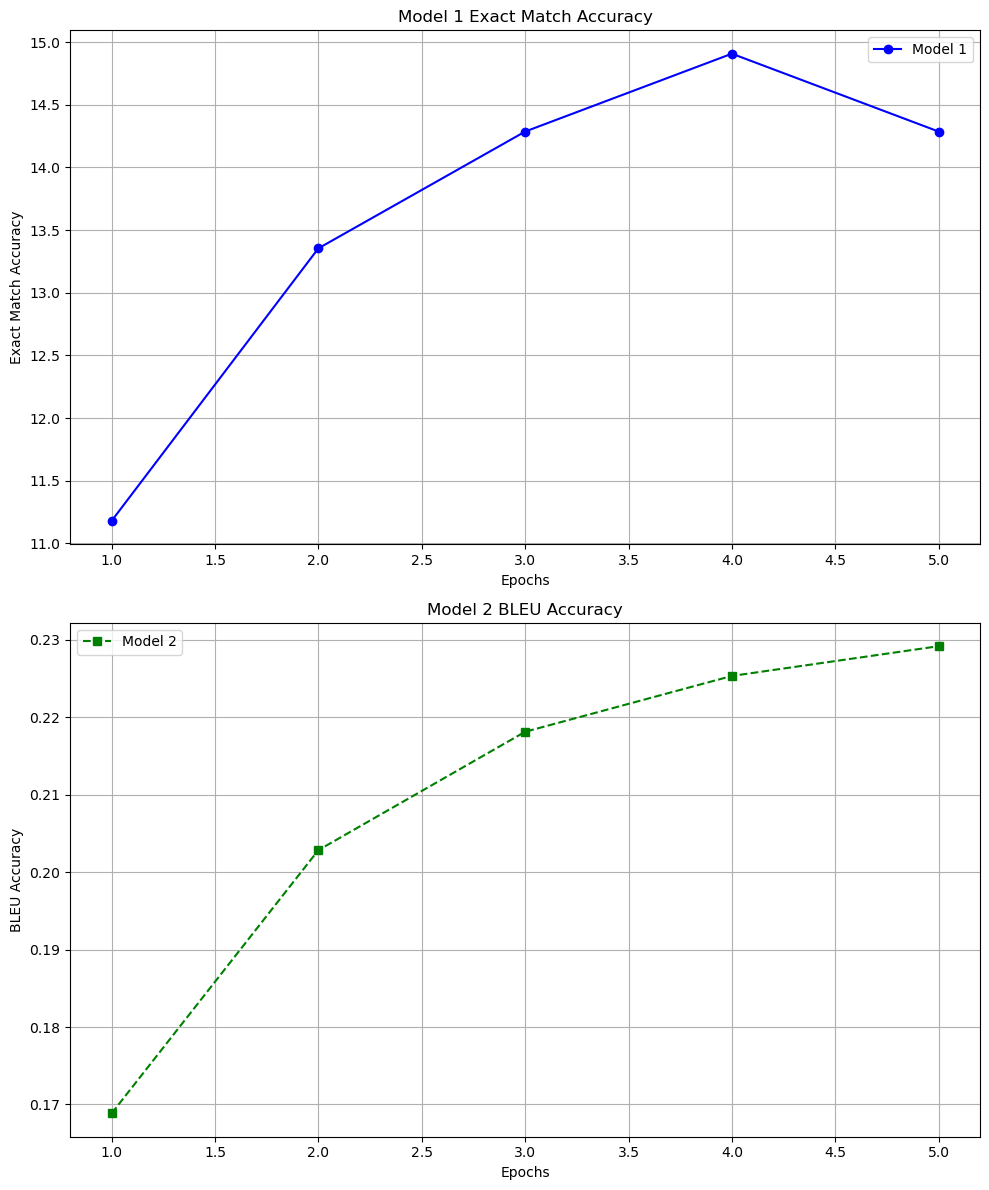

In [48]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]



# Create subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Model 1 accuracy on the first subplot
axs[0].plot(epochs, resulting_dataframe_roberta_passage_Em['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Exact Match Accuracy')
axs[0].set_title('Model 1 Exact Match Accuracy')
axs[0].grid(True)
axs[0].legend()

# Plot Model 2 accuracy on the second subplot
axs[1].plot(epochs, resulting_dataframe_roberta_passage_Belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Accuracy')
axs[1].set_title('Model 2 BLEU Accuracy')
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


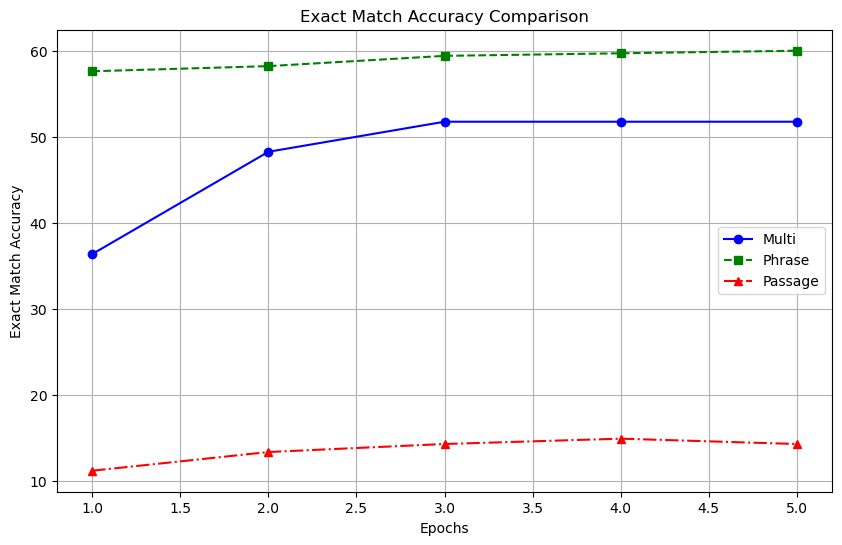

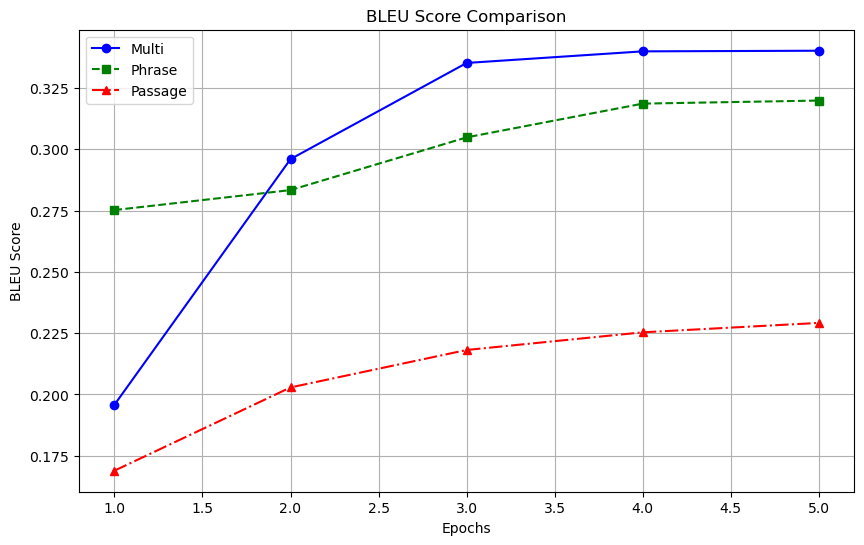

In [59]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]


# Create a plot for EM accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, resulting_dataframe_roberta_multi_Em['exact_match'], label='Multi', marker='o', linestyle='-', color='blue')
plt.plot(epochs, resulting_dataframe_roberta_phrase_Em['exact_match'], label='Phrase', marker='s', linestyle='--', color='green')
plt.plot(epochs, resulting_dataframe_roberta_passage_Em['exact_match'], label='Passage', marker='^', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Exact Match Accuracy')
plt.title('Exact Match Accuracy Comparison')
plt.grid(True)
plt.legend()

# Show the EM accuracy plot
plt.show()

# Create a plot for BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(epochs, resulting_dataframe_roberta_multi_Belu['bleu'], label='Multi', marker='o', linestyle='-', color='blue')
plt.plot(epochs, resulting_dataframe_roberta_phrase_Belu['bleu'], label='Phrase', marker='s', linestyle='--', color='green')
plt.plot(epochs, resulting_dataframe_roberta_passage_Belu['bleu'], label='Passage', marker='^', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Comparison')
plt.grid(True)
plt.legend()

# Show the BLEU score plot
plt.show()


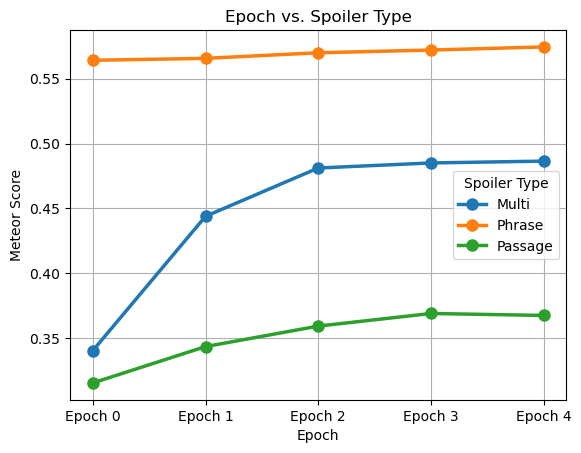

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for each data type and each epoch
data = {
    'Data Type': ['Multi', 'Phrase', 'Passage'],
    'Epoch 0': [0.3405, 0.5642, 0.3156],
    'Epoch 1': [0.4440, 0.5657, 0.3436],
    'Epoch 2': [0.4812, 0.5700, 0.3594],
    'Epoch 3': [0.4851, 0.5721, 0.3691],
    'Epoch 4': [0.4865, 0.5745, 0.3676]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Setting 'Data Type' column as the index for easy plotting
df.set_index('Data Type', inplace=True)

# Plotting each data type as a separate line
for data_type in df.index:
    plt.plot(df.columns, df.loc[data_type], marker='o', markersize=8, linewidth=2.5, label=data_type)

plt.xlabel('Epoch')
plt.ylabel('Meteor Score')
plt.title('Epoch vs. Spoiler Type')
plt.legend(title='Spoiler Type')
plt.grid(True)
plt.show()
